In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
# import dlib

In [35]:
def personDetector(frame):
    hog = cv2.HOGDescriptor()
    hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())
    frame = cv2.resize(frame, (480, 640))
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    
    boxes, weights = hog.detectMultiScale(frame, winStride=(8,8))
    boxes = np.array([[x, y, x + w, y + h] for (x, y, w, h) in boxes])
    
    for (xA, yA, xB, yB) in boxes:
        # display the detected boxes in the colour picture
        cv2.rectangle(frame, (xA, yA), (xB, yB), (0, 255, 0), 2)
    
    return frame, boxes, weights

[]
()


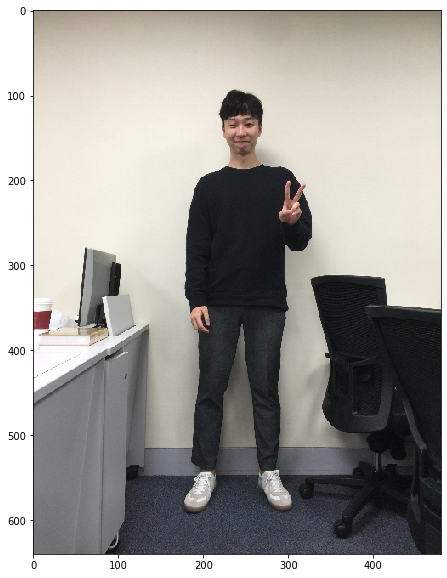

In [38]:
frame = cv2.imread('../Sample_Pic_OD/YK.jpg')
f, b, w = personDetector(frame)

plt.figure(figsize=[10,10])
plt.imshow(cv2.cvtColor(f, cv2.COLOR_BGR2RGB))
print(b)
print(w)

In [22]:
frame = cv2.imread('../Sample_Pic_OD/HJ.jpg')
protoFile = "../caffemodels/pose_deploy_linevec.prototxt"
weightFile = "../caffemodels/pose_iter_440000.caffemodel"
faceHarr = cv2.CascadeClassifier('../harrs/haarcascade_frontalface_default.xml')
network = cv2.dnn.readNetFromCaffe(protoFile, weightFile)

def getSkeleton(frame, network, face_cascade, isHarr=True):
    ### Inferencing Pose ###
    nPoints = 18
    POSE_PAIRS = [ [1,0],[1,2],[1,5],[2,3],[3,4],[5,6],\
                  [6,7],[1,8],[8,9],[9,10], [14,11], [11,12], [12,13] ]
    BODY_PARTS = { "Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
            "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
            "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "REye": 14,
            "LEye": 15, "REar": 16, "LEar": 17, "Background": 18 }
    idx_2_BODY_PARTS = {int(num):part for part, num in BODY_PARTS.items()}
    frameCopy = np.copy(frame)
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    threshold = 0.1
    
    # inHeight / inWidth
    inWidth = 368
    inHeight = 368
    inpBlob = cv2.dnn.blobFromImage(frame, 1.0/255, (inWidth, inHeight),\
                                   (0,0,0), swapRB=False, crop=False)
    
    dotsize = int((frameWidth + frameHeight) / (inWidth))
    textsize = int((frameWidth + frameHeight) / (inWidth * 4))
    
    network.setInput(inpBlob)
    
    output = network.forward()
    H = output.shape[2]
    W = output.shape[3]
    
    points = []
    points_with_num = []
    facelist = []
    
    ### Inferencing face & emotion ###
    if isHarr:
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        facelist = face_cascade.detectMultiScale(gray, 1.3, 5)
        facelist = list(np.array(facelist).flatten())
    else:
        import dlib
        hogFaceDetector = dlib.get_frontal_face_detector()
        faceRects = hogFaceDetector(frame, 0)
        facelist = [faceRects[0].left(),faceRects[0].top(),\
                                              faceRects[0].right()-faceRects[0].left(), faceRects[0].bottom()-faceRects[0].top()]
    
    emotion = None
    print(facelist)
    if len(facelist)!=0:
        (fx,fy,fw,fh) = facelist[:4]
        face = cv2.cvtColor(frame[fx:fx+fw, fy:fy+fh], cv2.COLOR_BGR2GRAY)
        face = cv2.resize(face, dsize=(48, 48), interpolation=cv2.INTER_LINEAR)
        input_face= face.reshape(-1,48,48,1)
        model = load_model()

        label_dict = {'Angry': 0, 'Disgust': 1, 'Fear': 2, 'Happy': 3, 'Neutral': 4, 'Sad': 5, 'Surprise': 6}
        label_dict = {num:emotion for emotion, num in label_dict.items()}
        emotion = label_dict[np.argmax(model.predict(input_face))]
    
    ### Draw points, lines, rectangle ###
    ### Pose estimation ###
    for i in range(nPoints):
        # confidence map of corresponding body's part
        probMap = output[0, i, :, :]
        minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)
        
        x = (frameWidth * point[0]) / W
        y = (frameHeight * point[1]) / H
        
        if prob > threshold:
            cv2.circle(frameCopy, (int(x), int(y)), dotsize, (0,255,255),\
                      thickness=dotsize, lineType=cv2.FILLED)
            cv2.putText(frameCopy, "{}".format(i), (int(x), int(y)),\
                       cv2.FONT_HERSHEY_SIMPLEX, textsize, (0,0,255), textsize, \
                       lineType=cv2.LINE_AA)
            cv2.circle(frame, (int(x), int(y)), dotsize, (0, 0, 255),\
                       thickness=dotsize, lineType=cv2.FILLED)
            # Add the point to the list if the probability is greater than the threshold
            points.append((int(x), int(y)))
            points_with_num.append((int(x), int(y), int(i), idx_2_BODY_PARTS[int(i)]))
        else:
            points.append(None)
    
    # Draw Skeleton
    for pair in POSE_PAIRS:
        partA = pair[0]
        partB = pair[1]
        
        if points[partA] and points[partB]:
            cv2.line(frame, points[partA], points[partB], (0,255,255), 3)
    
    ### Draw Face box and emotion ###
    if len(facelist)!=0:
        cv2.rectangle(frame, (fx,fy),(fx+fw,fy+fh),(0,255,255), 3)
        cv2.rectangle(frameCopy, (fx,fy),(fx+fw,fy+fh),(0,255,255), 3)
    
    img_skeleton = frame
    img_with_dot = frameCopy
    return img_skeleton, img_with_dot, points_with_num, emotion
    

In [3]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, Input
from keras.preprocessing.image import ImageDataGenerator
import os
from keras.models import Sequential, Model
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers.advanced_activations import ELU
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras.optimizers import RMSprop, SGD, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import regularizers
from keras.regularizers import l1, l2
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau

Using TensorFlow backend.
/home/KTH/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/KTH/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/KTH/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/KTH/.local/lib/python3.6/site-packages/tensorflow/python/framework/d

In [4]:
def resnet_layer(inputs,
                num_filters=16,
                kernel_size=3,
                strides=1,
                activation='relu',
                batch_normalization=True,
                conv_first=True):
    conv = Conv2D(num_filters,
                 kernel_size=strides,
                 padding='same',
                 kernel_initializer='he_normal',
                 kernel_regularizer=l2(1e-4))
    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [5]:
def resnet_v2(input_shape, depth, num_classes=7):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
    input_shape (tensor): shape of input image tensor
    depth (int): number of core convolutional layers
    num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
    model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
        
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)
    
    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs,
                    num_filters=num_filters_in,
                    conv_first=True)
    
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            # num of param setting 
            if stage == 0: # first stage
                num_filters_out = num_filters_in * 4
                if res_block == 0: # first layer & first stage
                    activation = None
                    batch_normalization = False
            else: # second, third stage
                num_filters_out = num_filters_in * 2
                if res_block == 0: # first layer but no first stage
                    strides = 2 # downsample
            y = resnet_layer(inputs=x,
                            num_filters=num_filters_in,
                            kernel_size=1,
                            strides=strides,
                            activation=activation,
                            batch_normalization=batch_normalization,
                            conv_first=False)
            y = resnet_layer(inputs=y,
                            num_filters=num_filters_in,
                            conv_first=False)
            y = resnet_layer(inputs=y,
                            num_filters=num_filters_out,
                            kernel_size=1,
                            conv_first=False)
            if res_block == 0:
                # Linear projection residual shortcut connection to match
                # changed dims
                # at the first time, make a shortcut origin
                x = resnet_layer(inputs=x,
                                num_filters=num_filters_out,
                                kernel_size=1,
                                strides=strides,
                                activation=None,
                                batch_normalization=False)
            # and add every reputation
            x = keras.layers.add([x, y])
        
        num_filters_in = num_filters_out
    
    # Add classifier on top
    # v2 has BN_ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                   activation='softmax',
                   kernel_initializer='he_normal')(y)
    
    # Instantiate model
    model = Model(inputs=inputs, outputs=outputs)
    
    return model

In [6]:
def load_model(weight_path='../emotion_detector_models/model_resnet_best.hdf5'):
    # Create the model
    n = 6
    version = 2
    if version == 1:
        depth = n * 6 + 2
    elif version == 2:
        depth = n * 9 + 2

    input_shape = [48,48,1]

    model = resnet_v2(input_shape=input_shape, depth=depth)
    
    model.load_weights(weight_path)
    
    return model

[1065, 1033, 227, 227]
Surprise


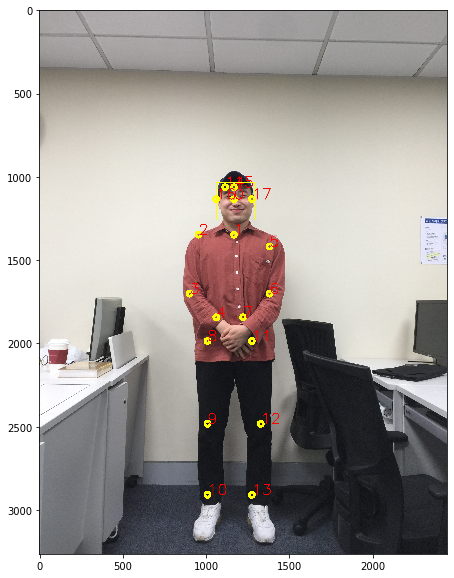

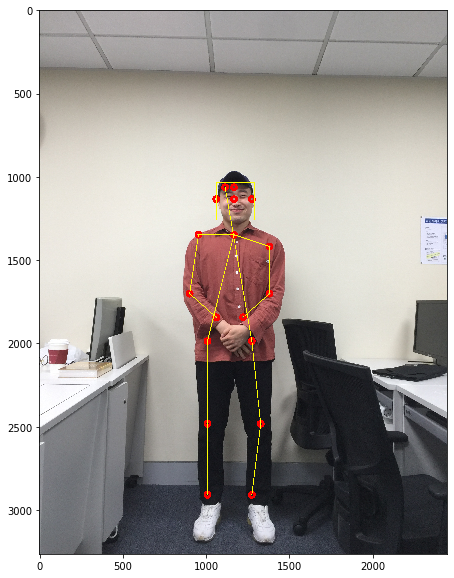

In [23]:
# 학습 후 inference

img_skeleton, img_with_dot, points, emotion = getSkeleton(frame, network, faceHarr)
plt.figure(figsize=[10,10])
plt.imshow(cv2.cvtColor(img_with_dot, cv2.COLOR_BGR2RGB))
plt.figure(figsize=[10,10])
plt.imshow(cv2.cvtColor(img_skeleton, cv2.COLOR_BGR2RGB))
print(emotion)

[1109, 575, 285, 285]
Surprise


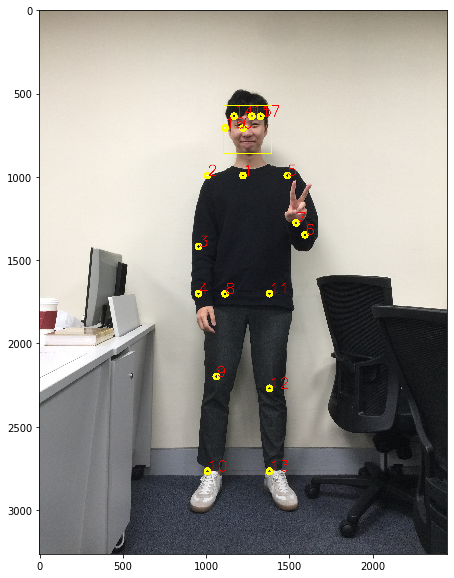

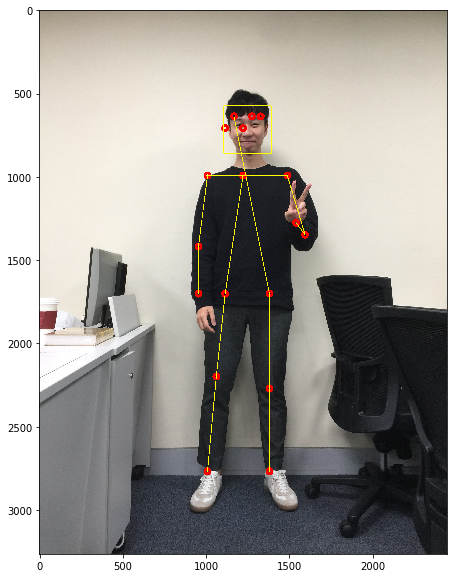

In [24]:
# 학습 후 inference

frame = cv2.imread('../Sample_Pic_OD/YK.jpg')

img_skeleton, img_with_dot, points, emotion = getSkeleton(frame, network, faceHarr)
plt.figure(figsize=[10,10])
plt.imshow(cv2.cvtColor(img_with_dot, cv2.COLOR_BGR2RGB))
plt.figure(figsize=[10,10])
plt.imshow(cv2.cvtColor(img_skeleton, cv2.COLOR_BGR2RGB))
print(emotion)

[1189, 1066, 206, 206]
Fear


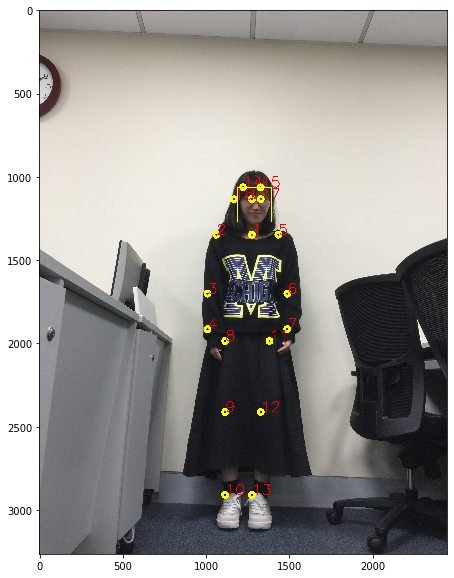

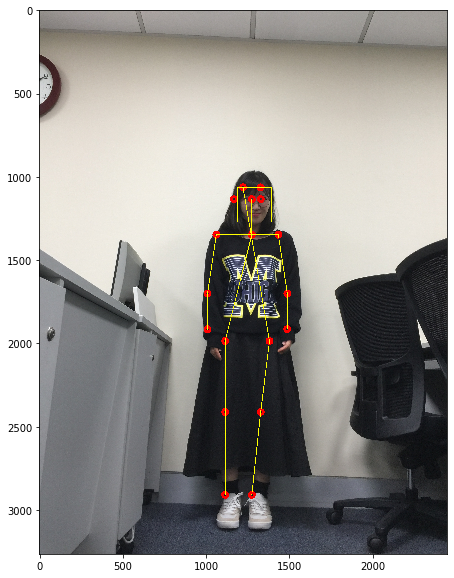

In [25]:
# 학습 후 inference

frame = cv2.imread('../Sample_Pic_OD/YJ.jpg')

img_skeleton, img_with_dot, points, emotion = getSkeleton(frame, network, faceHarr)
plt.figure(figsize=[10,10])
plt.imshow(cv2.cvtColor(img_with_dot, cv2.COLOR_BGR2RGB))
plt.figure(figsize=[10,10])
plt.imshow(cv2.cvtColor(img_skeleton, cv2.COLOR_BGR2RGB))
print(emotion)

[1154, 542, 238, 238, 1112, 579, 331, 331]
Angry


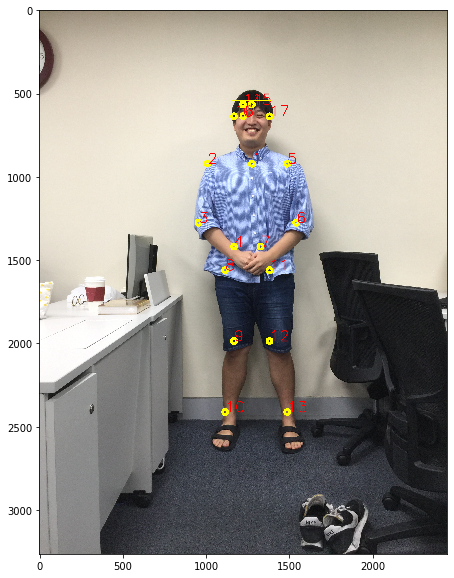

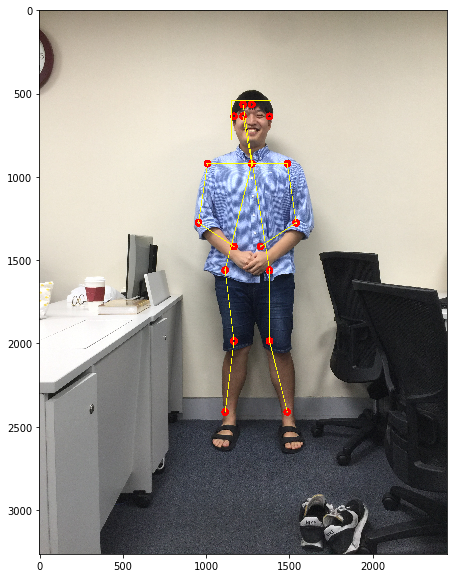

In [26]:
# 학습 후 inference

frame = cv2.imread('../Sample_Pic_OD/TH.jpg')

img_skeleton, img_with_dot, points, emotion = getSkeleton(frame, network, faceHarr)
plt.figure(figsize=[10,10])
plt.imshow(cv2.cvtColor(img_with_dot, cv2.COLOR_BGR2RGB))
plt.figure(figsize=[10,10])
plt.imshow(cv2.cvtColor(img_skeleton, cv2.COLOR_BGR2RGB))
print(emotion)